<font size=+3 color="#3B3534"><center><b>Housing in London 🏘️💷💂</b></center></font>

<img src="https://images.unsplash.com/photo-1501683567677-568cfd15361c?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=1414&q=80" width="750">


<br>

# Introduction

The topic of this notebook is the housing market of London in the years between 1995 and 2020. We are going to perform exploratory data analysis with the goal of discovering new information and answering the following questions:

- How has the housing market (average house price and number of houses sold) changed over the years in different boroughs of London? How does it compare to England?
- What factors affected it the most?

<br>

**Table of Contents**

1. [Introduction](#Introduction)
2. [Libraries](#Libraries)
3. [Meet the Datasets](#Datasets)
4. [London Housing over the Years](#Housing-over-the-Years)
5. [Factors Affecting Housing](#Factors-Affecting-Housing)
6. [Conclusions](#Conclusions)
7. [Future Developement](#Future-Developement)

# Libraries

We start by importing the necessary libraries and setting some parameters for the whole notebook (e.g. the display format for the pandas library).

In [1]:
pip install geopandas

  Obtaining dependency information for geopandas from https://files.pythonhosted.org/packages/cb/7b/2fb6ab376c78d2e60812ad0bf4b24889309d2aeb543f54efcd586c69907f/geopandas-0.13.2-py3-none-any.whl.metadata
  Obtaining dependency information for fiona>=1.8.19 from https://files.pythonhosted.org/packages/b0/7f/2de46a2630f609b7520d74ffc7692d4969b1fa1dd3c82f62c7967183d365/Fiona-1.9.4.post1-cp311-cp311-win_amd64.whl.metadata
     ---------------------------------------- 0.0/50.6 kB ? eta -:--:--
     ---------------------------------------- 50.6/50.6 kB 1.3 MB/s eta 0:00:00
  Obtaining dependency information for pyproj>=3.0.1 from https://files.pythonhosted.org/packages/c8/5a/215a1894e50167d91b471d8fc413ca30034c48e5d3dfac78d12df4c840d5/pyproj-3.6.0-cp311-cp311-win_amd64.whl.metadata
     ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
     -- ------------------------------------- 0.1/1.4 MB 2.6 MB/s eta 0:00:01
     ----- ---------------------------------- 0.2/1.4 MB 2.1 MB/

In [1]:
import numpy as np

import pandas as pd
from pandas.plotting import scatter_matrix
import geopandas as gpd

import matplotlib.pyplot as plt

import seaborn as sns

from IPython.display import HTML

import warnings
warnings.filterwarnings('ignore')

import gif

# Datasets

We are going to use the [Housing in London]dataset. It contains two csv files ('**housing_in_london_monthly_variables.csv**' and '**housing_in_london_yearly_variables.csv'**) with a lot of relevant information such as the monthly average house prices, yearly mean and median salary for residents of each area, etc.

The data is split by areas of London called boroughs, but some of the instances correspond to other UK regions (like North East, West Midlands, etc.).

Additionally, we are going to use a third dataset for plotting maps (**London Borough and Ward Boundaries up to 2014** )

# Housing over the Years

We are going to focus on the **average price** and the **number of houses sold** in each area. 

For this task, we need two datasets:
- '**housing_in_london_monthly_variables**' which contains monthly information about the London boroughs and the other UK regions, and
- '**London_Borough_Excluding_MHW.shp**' for plotting maps.

## Data Preprocessing

Let's import the first dataset and take a quick look at the data:

In [2]:
df_m = pd.read_csv('housing_in_london_monthly_variables.csv')

print ('This dataset contains {} rows and {} columns.'.format(df_m.shape[0], df_m.shape[1]))
df_m.head()

This dataset contains 13549 rows and 7 columns.


,date,area,average_price,code,houses_sold,no_of_crimes,borough_flag
0,1995-01-01,city of london,91449,E09000001,17.0,NaN,1
1,1995-02-01,city of london,82203,E09000001,7.0,NaN,1
2,1995-03-01,city of london,79121,E09000001,14.0,NaN,1
3,1995-04-01,city of london,77101,E09000001,7.0,NaN,1
4,1995-05-01,city of london,84409,E09000001,10.0,NaN,1


There are 7 attributes in total. An instance represents a London borough if 'borough_flag' equals 1. The meaning of the rest of the attributes can be easily inferred from their name.

The method `info()` can give us valuable information such as the type and the number of missing values in each attribute:

In [8]:
df_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13549 entries, 0 to 13548
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           13549 non-null  datetime64[ns]
 1   area           13549 non-null  object        
 2   average_price  13549 non-null  int64         
 3   code           13549 non-null  object        
 4   houses_sold    13549 non-null  float64       
 5   borough_flag   13549 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 635.2+ KB


In [6]:
null_df_m = df_m.isnull().sum().sort_values(ascending = False)
percent = (df_m.isnull().sum()/df_m.isnull().count()).sort_values(ascending = False)*100

null_df_m = pd.concat([null_df_m, percent], axis = 1, keys = ['Counts', '% Missing'])
print ('Missing: ')
null_df_m.head()

Missing: 


,Counts,% Missing
date,0,0.0
area,0,0.0
average_price,0,0.0
code,0,0.0
houses_sold,0,0.0


Two attributes, 'houses_sold' and 'no_of_crimes', have missing values. We will drop the whole 'no_of_crimes' attribute since almost 50% of its instances have NaN values. 

It's easier to replace missing values in the 'houses_sold' attribute as only a small portion is missing. We will use the mean value for the same area for all years in each case. Of course, someone could argue that this number would change over the years, but we could assume that the final results won't be affected due to small number of values being changed.

In [5]:
df_m.drop('no_of_crimes', axis = 1, inplace = True)   # drop the 'no_of_crimes column

df_m['houses_sold'].fillna(df_m.groupby('area')['houses_sold'].transform('mean'), inplace = True) # fill NaN values with the mean of that particular area

The 'date' attribute is of datatime type, hence we can extract the corresponding year of each instance (month and day are not important):

In [7]:
df_m['date'] = pd.to_datetime(df_m['date'])

In [9]:
df_m['year'] = df_m['date'].dt.year
df_m.iloc[[0, -1]]

,date,area,average_price,code,houses_sold,borough_flag,year
0,1995-01-01,city of london,91449,E09000001,17.000000,1,1995
13548,2020-01-01,england,247355,E92000001,77182.732441,0,2020


In [7]:
df_m['year'].max()

2020

## Data Exploration

According to Google, there are 33 boroughs in London (32 + the City of London). Is that the case in our dataset?

In [10]:
lnd_boroughs = df_m[df_m['borough_flag'] == 1]['area'].unique()
len(lnd_boroughs)

33

It is! How many and which regions are outside of London?

In [11]:
df_m[df_m['borough_flag'] == 0]['area'].nunique()

12

In [12]:
df_m[df_m['borough_flag'] == 0]['area'].unique()

array(['south east', 'inner london', 'outer london', 'north east',
       'north west', 'yorks and the humber', 'east midlands',
       'west midlands', 'east of england', 'london', 'south west',
       'england'], dtype=object)

We can manually isolate the ones that correspond to a region in England: 

In [13]:
eng_regions = ['south west', 'south east', 'east of england', 'west midlands', 'east midlands', 'yorks and the humber', 'north west', 'north east']

### London VS England

We can now split the dataset into two: one for boroughs in London and one for the other regions of England:

In [14]:
lnd = df_m[df_m['area'].isin(lnd_boroughs)]
eng = df_m[df_m['area'].isin(eng_regions)]

In [15]:
eng.head()

,date,area,average_price,code,houses_sold,borough_flag,year
3355,1998-04-01,south east,83176,E09000012,14030.488294,0,1998
3356,1998-04-01,south east,83176,E12000008,15354.000000,0,1998
10540,1995-01-01,north east,42076,E12000001,1983.000000,0,1995
10541,1995-02-01,north east,42572,E12000001,1986.000000,0,1995
10542,1995-03-01,north east,42370,E12000001,3052.000000,0,1995


#### Average Price

The `groupby()` method allows us to calculate the mean 'average price' for each 'date':

In [42]:
lnd_pr = lnd.groupby('date')['average_price'].mean()
eng_pr = eng.groupby('date')['average_price'].mean()

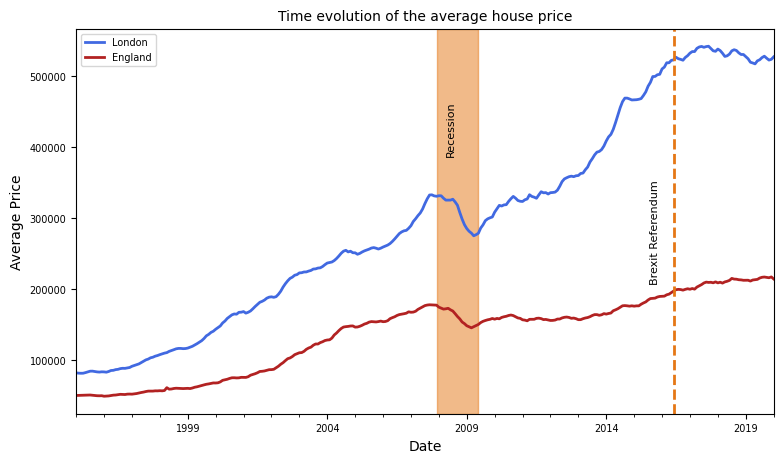

In [44]:
plt.figure(figsize = (9,5))
font_size=10

lnd_pr.plot(y = 'average_price', color = 'royalblue', lw = 2, label = 'London')
eng_pr.plot(y = 'average_price', color = 'firebrick', lw = 2, label = 'England')

plt.axvspan('2007-12-21', '2009-06-21', alpha = 0.5, color = '#E57715')
plt.text(x = '2008-04-01', y = 390000, s = 'Recession', rotation = 90, fontsize = font_size-2)
plt.axvline(x = '2016-06-23', lw = 2, color = '#E57715', linestyle = '--')
plt.text(x = '2015-08-01', y = 210000, s = 'Brexit Referendum', rotation = 90, fontsize = font_size-2)

plt.title('Time evolution of the average house price', size = font_size)
plt.ylabel('Average Price', size = font_size)
plt.xticks(size = font_size - 3)
plt.xlabel('Date', size = font_size)
plt.yticks(size = font_size - 3)
plt.legend(fontsize = font_size - 3);

- In overall, the averace price follows an **upward trend** during the studied time frame, with London always having a higher average price. 
- This upward trend was disrupted by the the **Great Recession** (2007-209), hence the significant **decline starting from 2007**. London apparently **recovered quickly** and the average price increased rapidly until 2016. **England** followed a similar behaviour but with a **moderate rise** in the same period.
- Arguably, the **[Brexit referendum]** had an impact in London housing since the average price hit a **plateau after 2016**. It seems the the rest of England wasn't affected as much from the referendum.

<br>



<br>

The average price in each borough fluctuates through time. However, we can calculate its mean which can give us a rough indication of how expensive each area is.

In [31]:
lnd_b_prices = lnd.groupby('area')['average_price'].mean()
lnd_top10_pr = lnd_b_prices.sort_values(ascending = False).to_frame()

print ('\nThe 10 most expensive boroughs in London are:')
lnd_top10_pr.tail()


The 10 most expensive boroughs in London are:


,average_price
area,
croydon,209349.671096
havering,205026.664452
newham,195646.066445
bexley,189570.737542
barking and dagenham,159852.930233


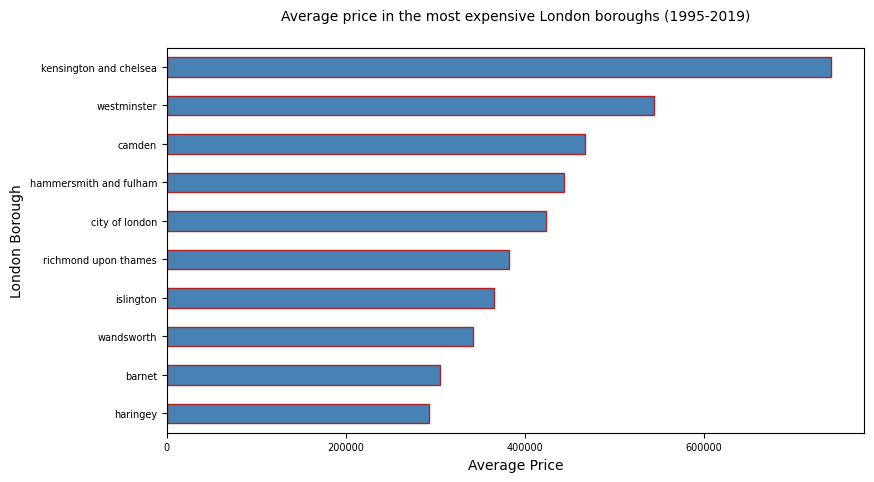

In [19]:
lnd_top10_pr.head(10).sort_values(by = 'average_price', ascending = True).plot(kind = 'barh', figsize = (9, 5), 
                                                                               color = 'steelblue', edgecolor = 'firebrick',
                                                                               legend = False)

plt.title('Average price in the most expensive London boroughs (1995-2019)', size = font_size, y = 1.05)
plt.ylabel('London Borough', size = font_size)
plt.yticks(size = font_size - 3)
plt.xlabel('Average Price', size = font_size)
plt.xticks([0, 200_000, 400_000, 600_000], size = font_size - 3);

We focus on the 5 most expensive boroughs and see the evolution of the average price through time:

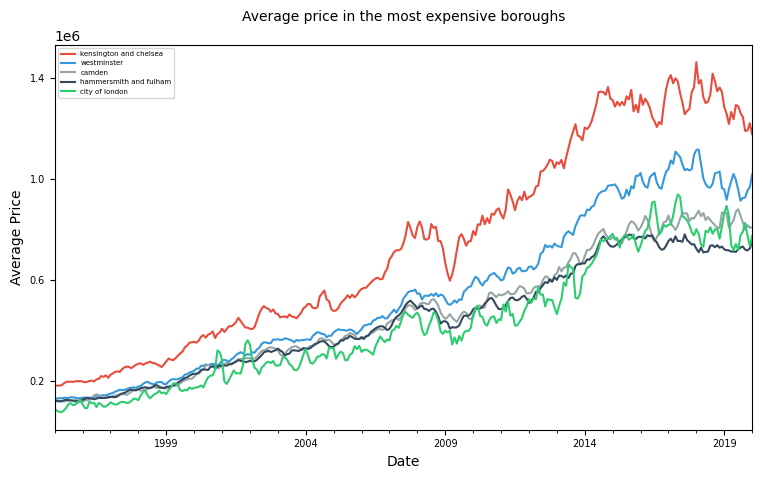

In [20]:
top5_indeces = lnd_top10_pr.head().index
colors = ['#e74c3c', '#3498db', '#95a5a6', '#34495e', '#2ecc71']

plt.figure(figsize = (9, 5))

for index, i in enumerate(top5_indeces):
    df_ = lnd[lnd['area'] == i]
    df_ = df_.groupby('date')['average_price'].mean()
    
    df_.plot(y = 'average_price', label = i, color = colors[index])
       
plt.title('Average price in the most expensive boroughs', y = 1.04, size = font_size)
plt.xlabel('Date', size = font_size)
plt.xticks(size = font_size - 3)
plt.ylabel('Average Price', size = font_size)
plt.yticks([0.2*1E+6, 0.6*1E+6, 1.0*1E+6, 1.4*1E+6], size = font_size - 3)
plt.legend(fontsize = font_size - 5);

- **Kensington and Chelsea** is the **most expensive borough** in London between 1995 and 2019. We can read in [wikipedia](https://en.wikipedia.org/wiki/Royal_Borough_of_Kensington_and_Chelsea) that it holds royal status and it includes many affluent areas, hence the increased price.
- **Westministe**r, which is adjacent to Kensighton, comes **second**. Again this is not a surpise since it is the location of the national government and includes many sites commonly associated with London (e.g. the Buckingham Palace, the Houses of Parliament, 10 Downing Street, and Trafalgar Square) ([Source](https://en.wikipedia.org/wiki/City_of_Westminster)).

We can perform a similar analysis for England:

In [33]:
eng_prices = eng.groupby('area')['average_price'].mean()
eng_top3_pr = eng_prices.sort_values(ascending = False).to_frame()

print('The top 3 most expensive regions in England are:')
eng_top3_pr.head(3)

The top 3 most expensive regions in England are:


,average_price
area,
south east,196067.076159
east of england,171182.229236
south west,163353.252492


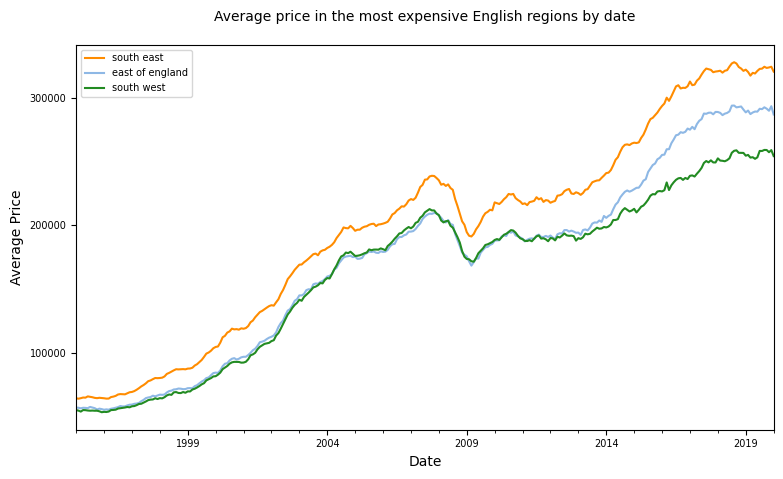

In [46]:
top3_indeces = eng_top3_pr.head(3).index
colors = ['darkorange', '#8EB8E5', 'forestgreen', ]

plt.figure(figsize = (9, 5))

for index, i in enumerate(top3_indeces):
    df_ = eng[eng['area'] == i]
    df_ = df_.groupby('date')['average_price'].mean()
    df_.plot(y = 'average_price' label = i, color = colors[index])

plt.title('Average price in the most expensive English regions by date', size = font_size, y = 1.04)
plt.xlabel('Date', size = font_size)
plt.xticks(size = font_size - 3)
plt.ylabel('Average Price', size = font_size)
plt.yticks([100_000, 200_000, 300_000], size = font_size - 3)
plt.legend(fontsize = font_size - 3);

The three **most expensive English regions** are all located in the **South of England** (two of them border London). It would be interesting to plot the same graph but with the cheapest borough of London (which we can find is Barking and Dagenham):

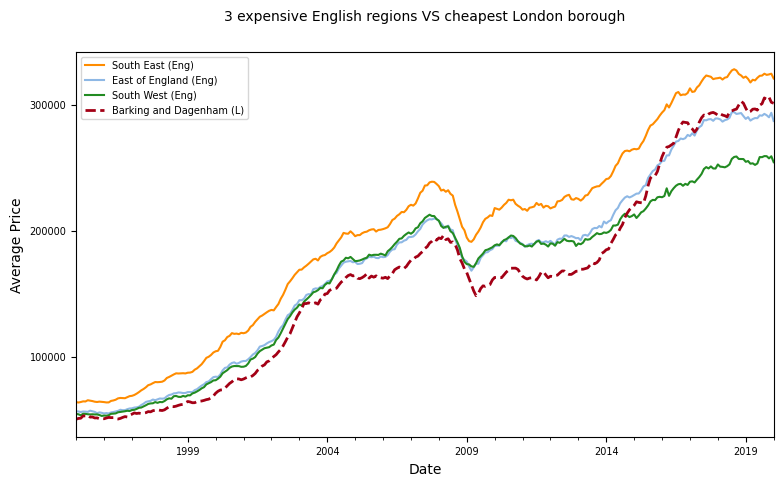

In [23]:
plt.figure(figsize = (9, 5))

for index, i in enumerate(top3_indeces):
    df_ = eng[eng['area'] == i]
    df_ = df_.groupby('date')['average_price'].mean()
    df_.plot(y = 'average_price', label = i, color = colors[index])

lnd_bng_pr = lnd[lnd['area'] == 'barking and dagenham'].groupby('date')['average_price'].mean()
lnd_bng_pr.plot(y = 'average_price', lw = 2, linestyle = '--', color = '#A30015', label = 'barking and dagenham')

plt.title('3 expensive English regions VS cheapest London borough', size = font_size, y = 1.06)
plt.xlabel('Date', size = font_size)
plt.xticks(size = font_size - 3)
plt.ylabel('Average Price', size = font_size)
plt.yticks([0.1*1E+6, 0.2*1E+6, 0.3*1E+6], size = font_size - 3)
plt.legend(labels = ['South East (Eng)', 'East of England (Eng)', 'South West (Eng)', 'Barking and Dagenham (L)'], 
           fontsize = font_size - 3);

It is evident that even the cheapest borough in London is **comparable** to the most expensive regions of England!

### Houses Sold

Let's explore the 'houses_sold' attribute for London.

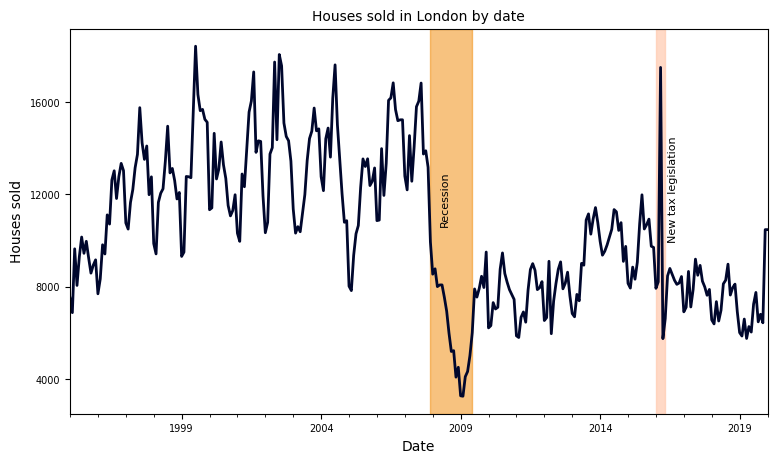

In [24]:
lnd_houses = lnd.groupby('date')['houses_sold'].sum()
lnd_houses.plot(figsize = (9, 5), lw = 2, y = 'houses_sold', color = '#00072D')

plt.axvspan('2007-12-21', '2009-06-21', alpha = 0.5, color = '#F08700')
plt.text(x = '2008-04-01', y = 10700, s = 'Recession', rotation = 90, fontsize = font_size-2)
plt.axvspan('2016-01-1', '2016-05-01', alpha = 0.7, color = '#FFCAAF')

# plt.axvline(x = '2016-06-23', lw = 2, color = '#E57715', linestyle = '--')
plt.text(x = '2016-06-01', y = 10000, s = 'New tax legislation', rotation = 90, fontsize = font_size-2)

plt.title('Houses sold in London by date', size = font_size)
plt.xlabel('Date', size = font_size)
plt.xticks(size = font_size - 3)
plt.ylabel('Houses sold', size = font_size)
plt.yticks([4000, 8000, 12000, 16000], size = font_size - 3);

- The number of houses sold in London **dropped sharply** during the **financial recession** and it seems that it **hasn't completely recovered** since,  
- Interestingly, there is **spike in March 2016** which at first sight looks like a artefact. That is not the case, because people were actually trying to avoid a **new legislation** that came into effect in April 2016 and imposed an increase in the tax bill on buying a second home. 
- Again, the **referendum** resulted in a **downward trend** starting from July 2016.

<br>

The boroughs with the highest number of sold houses between 1995 and 2019 are:

In [25]:
lnd_b_houses = lnd.groupby('area')['houses_sold'].sum()
lnd_top5_h = lnd_b_houses.sort_values(ascending = False).to_frame()
lnd_top5_h.head(5)

,houses_sold
area,
wandsworth,164967.127090
bromley,149509.418060
croydon,146881.959866
barnet,134541.966555
lambeth,118741.983278


To better understand these numbers we need more information such as the size of the borough, its population, crime rates etc. Some of these information are available in the other dataset ('housing_in_london_yearly_variables').

## 

Map of London

We are going to use the **second dataset** which contains geospatial information about London (specifically, the 'geometry' attribute). 

We start by merging the two datasets:

In [15]:
import os

os.environ['SHAPE_RESTORE_SHX'] = 'YES'
# Now, proceed to open the shapefile using Geopandas or other GIS libraries

In [50]:
london_map = gpd.read_file('London_Wards/Boroughs/London_Borough_Excluding_MHW.shp')
london_map.columns = london_map.columns.str.lower()
london_map.head()

,name,gss_code,hectares,nonld_area,ons_inner,sub_2009,sub_2006,geometry
0,Kingston upon Thames,E09000021,3726.117,0.000,F,NaN,NaN,"POLYGON ((516401.600 160201.800, 516407.300 16..."
1,Croydon,E09000008,8649.441,0.000,F,NaN,NaN,"POLYGON ((535009.200 159504.700, 535005.500 15..."
2,Bromley,E09000006,15013.487,0.000,F,NaN,NaN,"POLYGON ((540373.600 157530.400, 540361.200 15..."
3,Hounslow,E09000018,5658.541,60.755,F,NaN,NaN,"POLYGON ((521975.800 178100.000, 521967.700 17..."
4,Ealing,E09000009,5554.428,0.000,F,NaN,NaN,"POLYGON ((510253.500 182881.600, 510249.900 18..."


In [51]:
london_map['name'] = london_map['name'].str.lower()
london_map.rename(columns = {'name': 'area'}, inplace = True)
london_map.rename(columns = {'gss_code': 'code'}, inplace = True)

london_map = london_map[['area', 'code', 'hectares', 'geometry']]
london_map.head()

,area,code,hectares,geometry
0,kingston upon thames,E09000021,3726.117,"POLYGON ((516401.600 160201.800, 516407.300 16..."
1,croydon,E09000008,8649.441,"POLYGON ((535009.200 159504.700, 535005.500 15..."
2,bromley,E09000006,15013.487,"POLYGON ((540373.600 157530.400, 540361.200 15..."
3,hounslow,E09000018,5658.541,"POLYGON ((521975.800 178100.000, 521967.700 17..."
4,ealing,E09000009,5554.428,"POLYGON ((510253.500 182881.600, 510249.900 18..."


In [52]:
lnd_m = lnd.groupby('area').agg({'average_price': ['mean'], 'houses_sold': 'sum'})

lnd_m.columns = ['average_price', 'houses_sold']
lnd_m.reset_index(inplace = True)
lnd_m.head()

,area,average_price,houses_sold
0,barking and dagenham,159852.930233,59895.979933
1,barnet,304991.089701,134541.966555
2,bexley,189570.737542,98002.177258
3,brent,270291.252492,82158.906355
4,bromley,254160.621262,149509.418060


Remember that London has 33 boroughs, same as the lnd_tot dataset. Let's check that the london_map dataset has the same names:

In [53]:
np.intersect1d(lnd_m['area'], london_map['area']).size

33

It does, so we are good to go.

In [54]:
lnd_m_map = pd.merge(london_map, lnd_m, how = 'inner', on = 'area')
lnd_m_map.head()

,area,code,hectares,geometry,average_price,houses_sold
0,kingston upon thames,E09000021,3726.117,"POLYGON ((516401.600 160201.800, 516407.300 16...",281688.425249,76132.866221
1,croydon,E09000008,8649.441,"POLYGON ((535009.200 159504.700, 535005.500 15...",209349.671096,146881.959866
2,bromley,E09000006,15013.487,"POLYGON ((540373.600 157530.400, 540361.200 15...",254160.621262,149509.418060
3,hounslow,E09000018,5658.541,"POLYGON ((521975.800 178100.000, 521967.700 17...",235965.421927,86043.719064
4,ealing,E09000009,5554.428,"POLYGON ((510253.500 182881.600, 510249.900 18...",274537.322259,110778.066890


In [55]:
type(lnd_m_map)

geopandas.geodataframe.GeoDataFrame

<Axes: >

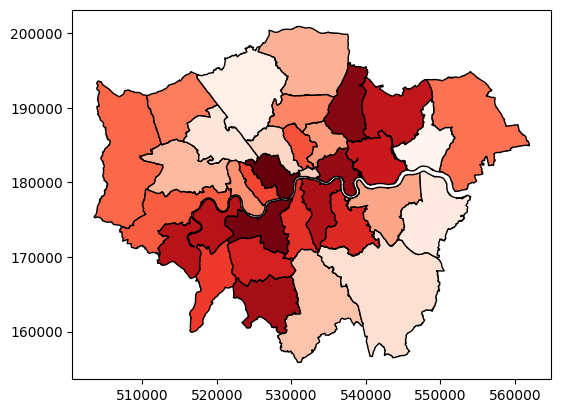

In [64]:
london_map.plot(cmap='Reds',column='area',edgecolor='black')

The merged dataset has a new type, **geodataframe**, which is what we need for plotting the map.

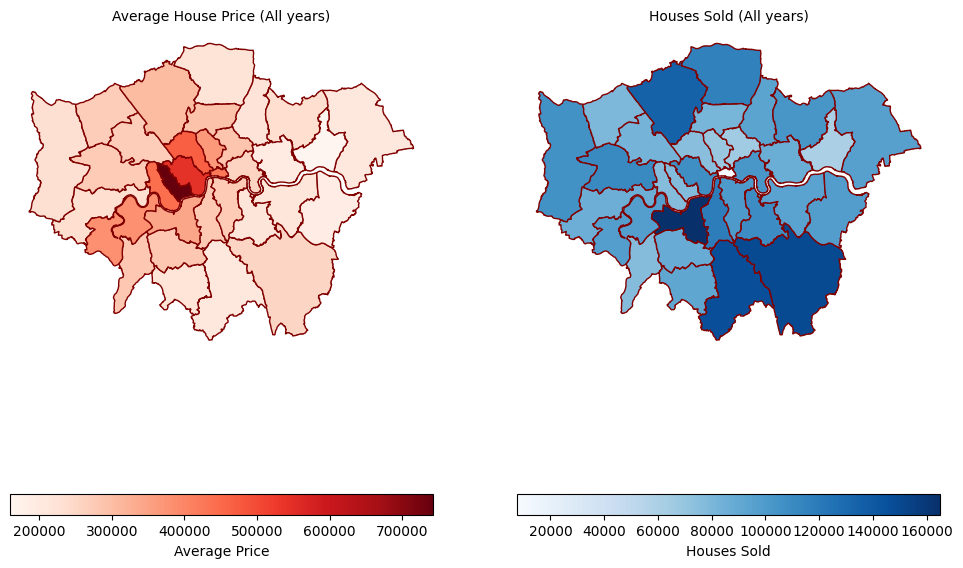

In [66]:
font_size = 10
fig, ax = plt.subplots(1, 2, figsize = (12, 12))

lnd_m_map.plot(ax = ax[0], column = 'average_price', cmap = 'Reds', edgecolor = 'maroon', legend = True, legend_kwds = {'label': 'Average Price', 'orientation' : 'horizontal'})

lnd_m_map.plot(ax = ax[1], column = 'houses_sold', cmap = 'Blues', edgecolor = 'maroon', legend = True, legend_kwds = {'label': 'Houses Sold', 'orientation' : 'horizontal'})

ax[0].axis('off')
ax[0].set_title('Average House Price (All years)', size = font_size)
ax[1].axis('off')
ax[1].set_title('Houses Sold (All years)', size = font_size);

- We can now see Kensighton and Westminister as the two dark boroughs in the first map. We can roughly say that boroughs **closer** to these two areas are **more expensive**.
- As we hinted earlier, the number of houses sold is probably affected by many factors with one of them being the **total area** of each borough. We can definetely see that larger boroughs have more houses sold.

---

# Factors Affecting Housing

## Preparing the Final Dataset

For this question we need to import the third and final dataset ('**housing_in_london_yearly_variables**') which we are going to merge with the monthly dataset.

In [27]:
df_y = pd.read_csv('housing_in_london_yearly_variables.csv', parse_dates = ['date'])
df_y = df_y[df_y['area'].isin(lnd_boroughs)] # select only London boroughs

print ('This dataset contains {} rows and {} columns.'.format(df_y.shape[0], df_y.shape[1]))
df_y.head()

This dataset contains 693 rows and 12 columns.


,code,area,date,median_salary,life_satisfaction,mean_salary,recycling_pct,population_size,number_of_jobs,area_size,no_of_houses,borough_flag
0,E09000001,city of london,1999-12-01,33020.0,NaN,48922,0,6581.0,NaN,NaN,NaN,1
1,E09000002,barking and dagenham,1999-12-01,21480.0,NaN,23620,3,162444.0,NaN,NaN,NaN,1
2,E09000003,barnet,1999-12-01,19568.0,NaN,23128,8,313469.0,NaN,NaN,NaN,1
3,E09000004,bexley,1999-12-01,18621.0,NaN,21386,18,217458.0,NaN,NaN,NaN,1
4,E09000005,brent,1999-12-01,18532.0,NaN,20911,6,260317.0,NaN,NaN,NaN,1


This dataset has more information for each borough and is ideal for answering the second question. Let's see how many missing values each attrbitutes has:

In [55]:
pd.set_option('display.max_rows',693)

In [60]:
df_y.head()

,code,area,date,median_salary,life_satisfaction,mean_salary,recycling_pct,population_size,number_of_jobs,area_size,no_of_houses,borough_flag
0,E09000001,city of london,1999-12-01,33020.0,NaN,48922,0,6581.0,NaN,NaN,NaN,1
1,E09000002,barking and dagenham,1999-12-01,21480.0,NaN,23620,3,162444.0,NaN,NaN,NaN,1
2,E09000003,barnet,1999-12-01,19568.0,NaN,23128,8,313469.0,NaN,NaN,NaN,1
3,E09000004,bexley,1999-12-01,18621.0,NaN,21386,18,217458.0,NaN,NaN,NaN,1
4,E09000005,brent,1999-12-01,18532.0,NaN,20911,6,260317.0,NaN,NaN,NaN,1
5,E09000006,bromley,1999-12-01,16720.0,NaN,21293,13,294902.0,NaN,NaN,NaN,1
6,E09000007,camden,1999-12-01,23677.0,NaN,30249,13,190003.0,NaN,NaN,NaN,1
7,E09000008,croydon,1999-12-01,19563.0,NaN,22205,13,332066.0,NaN,NaN,NaN,1
8,E09000009,ealing,1999-12-01,20580.0,NaN,25046,12,302252.0,NaN,NaN,NaN,1
9,E09000010,enfield,1999-12-01,19289.0,NaN,21006,9,272731.0,NaN,NaN,NaN,1


In [59]:
df_y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 693 entries, 0 to 1052
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   code               693 non-null    object        
 1   area               693 non-null    object        
 2   date               693 non-null    datetime64[ns]
 3   median_salary      683 non-null    float64       
 4   life_satisfaction  256 non-null    float64       
 5   mean_salary        693 non-null    object        
 6   recycling_pct      660 non-null    object        
 7   population_size    660 non-null    float64       
 8   number_of_jobs     627 non-null    float64       
 9   area_size          594 non-null    float64       
 10  no_of_houses       594 non-null    float64       
 11  borough_flag       693 non-null    int64         
dtypes: datetime64[ns](1), float64(6), int64(1), object(4)
memory usage: 70.4+ KB


In [49]:
null_df_y = df_y.isnull().sum().sort_values(ascending = False)
percent = (df_y.isnull().sum()/df_y.isnull().count()).sort_values(ascending = False)*100

null_df = pd.concat([null_df_y, percent], axis = 1, keys = ['Counts', '%'])
null_df.head(10)

,Counts,%
life_satisfaction,437,63.059163
area_size,99,14.285714
no_of_houses,99,14.285714
number_of_jobs,66,9.523810
recycling_pct,33,4.761905
population_size,33,4.761905
median_salary,10,1.443001
code,0,0.000000
area,0,0.000000
date,0,0.000000


It seems that all new attributes have missing values. Pandas' `corr()` function, which we are going to use later, ignores a pairwise correlation if there is a NaN value in one of the observations, so we shouldn't worry about it for now.

'median_salary' is not currently numeric. If we try to convert it to numeric (with the `astype()` method), we'll get an error. That's because some instances contain symbols and need to be replaced first:

In [28]:
df_y['area'].value_counts()

city of london            21
hounslow                  21
wandsworth                21
waltham forest            21
tower hamlets             21
sutton                    21
southwark                 21
richmond upon thames      21
redbridge                 21
newham                    21
merton                    21
lewisham                  21
lambeth                   21
kingston upon thames      21
kensington and chelsea    21
islington                 21
hillingdon                21
barking and dagenham      21
havering                  21
harrow                    21
haringey                  21
hammersmith and fulham    21
hackney                   21
greenwich                 21
enfield                   21
ealing                    21
croydon                   21
camden                    21
bromley                   21
brent                     21
bexley                    21
barnet                    21
westminster               21
Name: area, dtype: int64

In [65]:
df_y[~df_y['mean_salary'].str.isnumeric()]['mean_salary'].value_counts()

#    7
Name: mean_salary, dtype: int64

In [29]:
df_y['mean_salary'] = df_y['mean_salary'].replace(['#'], np.NaN)
df_y['mean_salary'] = df_y['mean_salary'].astype(float)

In [30]:
df_y['year'] = df_y['date'].dt.year

print ('yearly_variables dataset')
print ('\tFirst date: ', df_y['year'].min())
print ('\tFinal date: ', df_y['year'].max())

yearly_variables dataset
	First date:  1999
	Final date:  2019


This dataset starts four years later compared to the monthly dataset. Therefore, we need to merge them so that there is no mismatch in the 'year' column:

In [31]:
lnd_m_group = lnd.groupby(['area', 'year']).mean().reset_index()  # group based on area and year (take mean)
lnd_m_group = lnd_m_group[lnd_m_group['year'] >= 1999]            # select all years after 1999 (included)

print ('monthly_variables dataset')
print ('\tFirst date: ', lnd_m_group['year'].min())
print ('\tFinal date: ', lnd_m_group['year'].max())

monthly_variables dataset
	First date:  1999
	Final date:  2020


In [35]:
lnd_m_group.head()

,area,year,average_price,houses_sold,borough_flag
4,barking and dagenham,1999,65320.833333,223.833333,1.0
5,barking and dagenham,2000,77549.500000,234.416667,1.0
6,barking and dagenham,2001,88664.000000,266.916667,1.0
7,barking and dagenham,2002,112221.916667,287.416667,1.0
8,barking and dagenham,2003,142499.000000,301.250000,1.0


In [32]:
lnd.head()

,date,area,average_price,code,houses_sold,borough_flag,year
0,1995-01-01,city of london,91449,E09000001,17.0,1,1995
1,1995-02-01,city of london,82203,E09000001,7.0,1,1995
2,1995-03-01,city of london,79121,E09000001,14.0,1,1995
3,1995-04-01,city of london,77101,E09000001,7.0,1,1995
4,1995-05-01,city of london,84409,E09000001,10.0,1,1995


In [33]:
lnd_y_group = df_y.groupby(['area', 'year']).mean().reset_index() # group it based on area and year
lnd_y_group.head()

,area,year,median_salary,life_satisfaction,mean_salary,population_size,number_of_jobs,area_size,no_of_houses,borough_flag
0,barking and dagenham,1999,21480.0,NaN,23620.0,162444.0,NaN,NaN,NaN,1.0
1,barking and dagenham,2000,22618.0,NaN,24696.0,163893.0,57000.0,NaN,NaN,1.0
2,barking and dagenham,2001,22323.0,NaN,26050.0,165654.0,54000.0,3780.0,68298.0,1.0
3,barking and dagenham,2002,24813.0,NaN,26653.0,166357.0,52000.0,3780.0,68526.0,1.0
4,barking and dagenham,2003,25358.0,NaN,27792.0,166210.0,55000.0,3780.0,68837.0,1.0


The two datasets are ready to be merged:

In [34]:
lnd_total = pd.merge(lnd_y_group, lnd_m_group, on = ['area', 'year'], how = 'left')
lnd_total.drop(['borough_flag_x', 'borough_flag_y'], axis = 1, inplace = True)

lnd_total.head()

,area,year,median_salary,life_satisfaction,mean_salary,population_size,number_of_jobs,area_size,no_of_houses,average_price,houses_sold
0,barking and dagenham,1999,21480.0,NaN,23620.0,162444.0,NaN,NaN,NaN,65320.833333,223.833333
1,barking and dagenham,2000,22618.0,NaN,24696.0,163893.0,57000.0,NaN,NaN,77549.500000,234.416667
2,barking and dagenham,2001,22323.0,NaN,26050.0,165654.0,54000.0,3780.0,68298.0,88664.000000,266.916667
3,barking and dagenham,2002,24813.0,NaN,26653.0,166357.0,52000.0,3780.0,68526.0,112221.916667,287.416667
4,barking and dagenham,2003,25358.0,NaN,27792.0,166210.0,55000.0,3780.0,68837.0,142499.000000,301.250000


## Correlations

In [36]:
corr_table = lnd_total.corr()
corr_table['average_price'].sort_values(ascending = False)

average_price        1.000000
year                 0.640333
median_salary        0.584034
number_of_jobs       0.481682
mean_salary          0.479570
life_satisfaction    0.267131
no_of_houses        -0.059515
population_size     -0.135301
area_size           -0.332420
houses_sold         -0.409190
Name: average_price, dtype: float64

In [44]:
corr_table

,year,median_salary,life_satisfaction,mean_salary,population_size,number_of_jobs,area_size,no_of_houses,average_price,houses_sold
year,1.000000e+00,0.593734,0.569251,0.370205,0.250715,0.128952,2.506254e-14,0.163684,0.640333,-0.497138
median_salary,5.937338e-01,1.000000,0.026487,0.935421,-0.248329,0.614045,-4.053602e-01,-0.286293,0.584034,-0.545804
life_satisfaction,5.692509e-01,0.026487,1.000000,-0.010617,-0.049084,0.031593,1.701062e-01,-0.092920,0.267131,0.106370
mean_salary,3.702046e-01,0.935421,-0.010617,1.000000,-0.364893,0.674463,-4.332688e-01,-0.358203,0.479570,-0.456790
population_size,2.507152e-01,-0.248329,-0.049084,-0.364893,1.000000,-0.205217,4.818998e-01,0.945194,-0.135301,0.435718
number_of_jobs,1.289517e-01,0.614045,0.031593,0.674463,-0.205217,1.000000,-2.732394e-01,-0.078056,0.481682,-0.149106
area_size,2.506254e-14,-0.405360,0.170106,-0.433269,0.481900,-0.273239,1.000000e+00,0.425649,-0.332420,0.396857
no_of_houses,1.636844e-01,-0.286293,-0.092920,-0.358203,0.945194,-0.078056,4.256487e-01,1.000000,-0.059515,0.529427
average_price,6.403331e-01,0.584034,0.267131,0.479570,-0.135301,0.481682,-3.324201e-01,-0.059515,1.000000,-0.409190
houses_sold,-4.971378e-01,-0.545804,0.106370,-0.456790,0.435718,-0.149106,3.968571e-01,0.529427,-0.409190,1.000000


- It doesn't come as a surpise that apart from the year, the average price in London has a **significant positive correlation** with the **median and mean salary** along with the **number of jobs** in a borough. 
- There is **small positive correlation** with **life satisfaction**. More data for this attribute would be useful.
- As we discussed earlier, the most affluent boroughs happen to be small (see map) which explains the **negative correlation** with the **size** of an area. 
- The average price is also affected by the **number of houses sold**, since the former goes up when the later decreases (people sell higher when less houses are sold?).

We can summarise these correlations (along with all pair-wise correlations) with the following heatmap:

In [46]:
mask = np.triu(np.ones_like(corr_table,dtype=np.bool_))
mask

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [False,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [False, False,  True,  True,  True,  True,  True,  True,  True,
         True],
       [False, False, False,  True,  True,  True,  True,  True,  True,
         True],
       [False, False, False, False,  True,  True,  True,  True,  True,
         True],
       [False, False, False, False, False,  True,  True,  True,  True,
         True],
       [False, False, False, False, False, False,  True,  True,  True,
         True],
       [False, False, False, False, False, False, False,  True,  True,
         True],
       [False, False, False, False, False, False, False, False,  True,
         True],
       [False, False, False, False, False, False, False, False, False,
         True]])

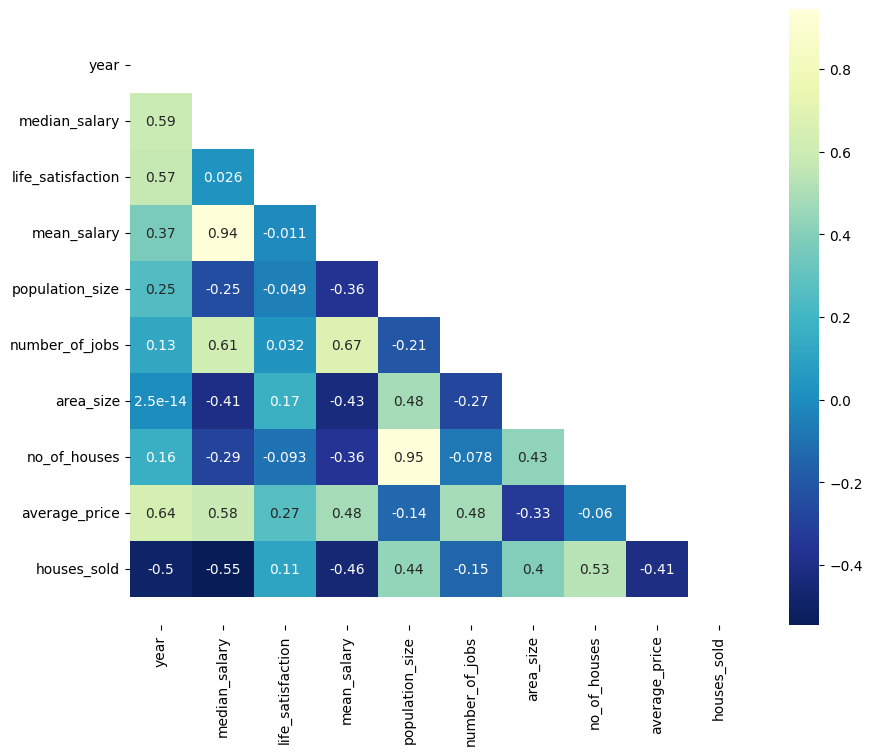

In [47]:
plt.figure(figsize = (10, 8))

mask = np.triu(np.ones_like(corr_table, dtype = np.bool_))

ax = sns.heatmap(corr_table, mask = mask, annot = True, cmap = 'YlGnBu_r')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5);

We can see some obvious correlations such as median-mean salary, houses sold-no_of_houses, no_of_houses-population_size, etc.

Lastly, a linear relationship between attributes can be visualised with the `scatter_matrix` method:

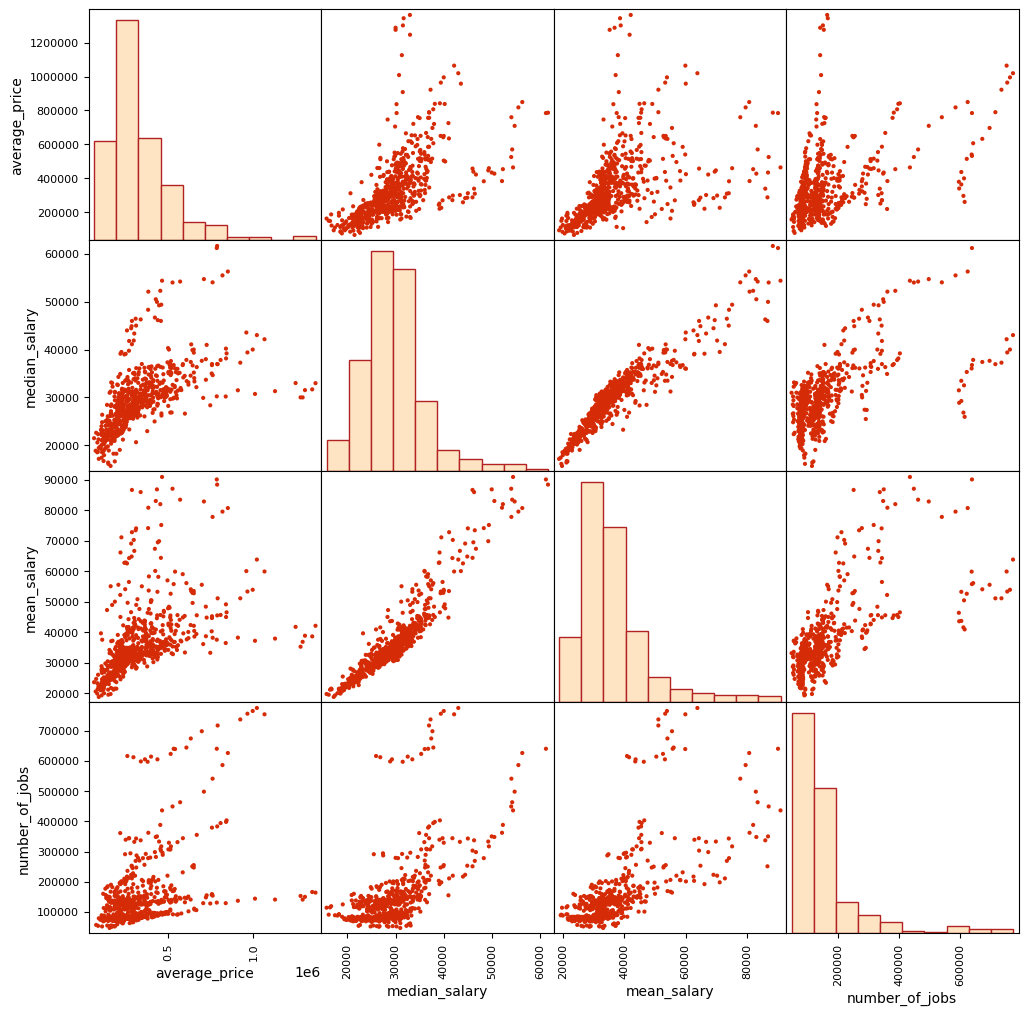

In [48]:
columns = ['average_price', 'median_salary', 'mean_salary', 'number_of_jobs']

scatter_matrix(lnd_total[columns], figsize = (12, 12), color = '#D52B06', alpha = 1, 
               hist_kwds = {'color':['bisque'], 'edgecolor': 'firebrick'});

# Conclusions

The main conclusions are the following:

- The average price in **London boroughs** is **higher** compared to the rest of England. It has been **affected** by major financial and political events (such the Recession and Brexit), but has **significantly increased** from 1995 to 2019 (by a factor of 5),

- **Affluent regions** such as Kensighton and Westiminister have the **highest average price**, 

- The number of houses sold **plummeted** after the recession, **streadily increased** until 2016 but then again **dropped** after the referendum, 

- As anyone could predict, the main factor that influences the average price is the **financial prosperity** of the corresponding borough. Higher salaries and more jobs result in higher prices.